init res =  0
continuous model : 

a = 
-6.3 0.0 0.0 0.0 
1.0 0.0 0.0 0.0 
0.0 0.0 -0.9 0.0 
0.0 0.0 1.0 0.0 

b = 
-9.45 9.45 
0.0 0.0 
0.18 0.18 
0.0 0.0 

c = 
1.0 0.0 0.0 0.0 
0.0 1.0 0.0 0.0 
0.0 0.0 1.0 0.0 
0.0 0.0 0.0 1.0 


[[ 1. ]
 [-0.5]]
controller


k=
 [[-0.54707 -6.27477 14.09473 48.44428]
 [ 0.54707  6.27477 14.09473 48.44428]] 

ki=
 [[  0.      -22.36068   0.       70.71068]
 [  0.       22.36068   0.       70.71068]] 




simulation done


<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 500x500 with 0 Axes>

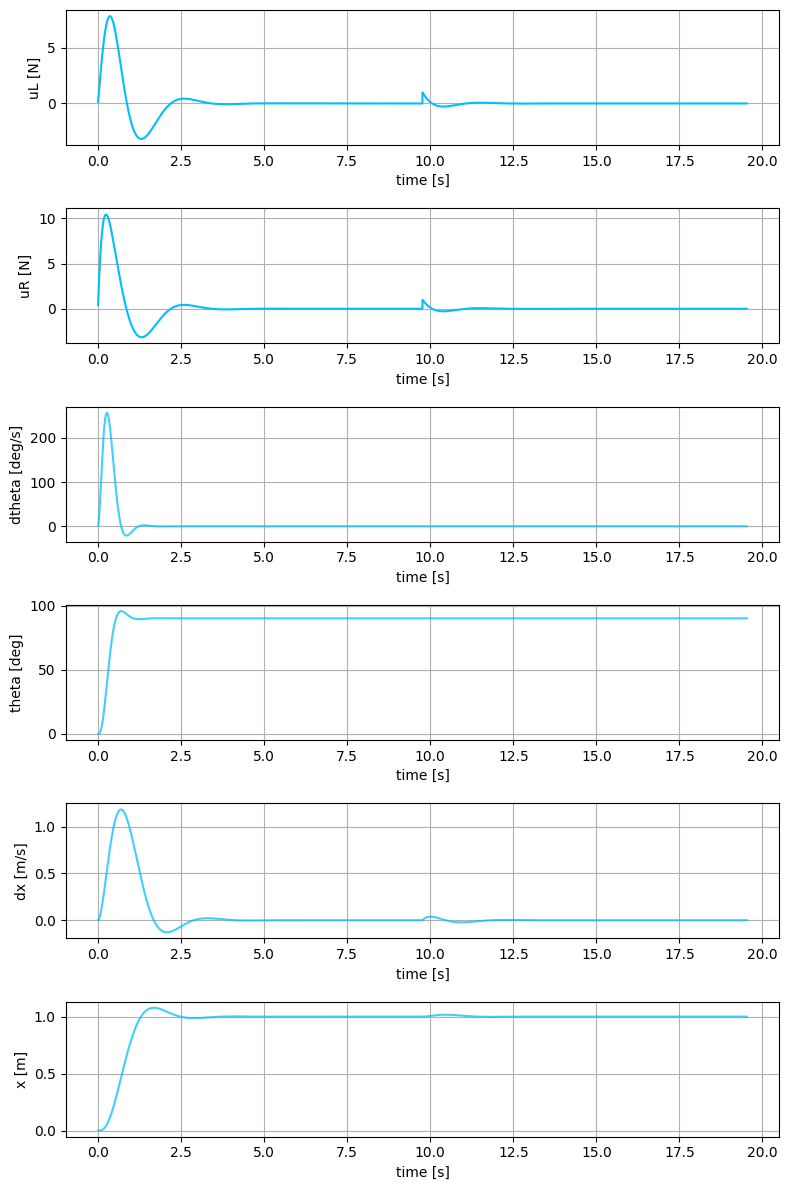

In [5]:
import LibsControl
import numpy
import matplotlib.pyplot as plt
import time

from differential_robot import *


def get_required(targets, current_target_idx, robot_x, robot_y, robot_theta):
        
        idx      = current_target_idx%targets.shape[0]
        
        x_pos    = targets[idx][0]
        y_pos    = targets[idx][1]

        d_distance = (x_pos - robot_x)**2 + (y_pos - robot_y)**2
        d_distance = d_distance**0.5

        required_theta    = numpy.arctan2(y_pos - model.y_pos, x_pos - model.x_pos)
        required_theta    = numpy.mod(required_theta, 2.0*numpy.pi)

        d_theta = required_theta - robot_theta

        if d_theta < 0:
            d_theta+= 2.0*numpy.pi
        if d_theta > numpy.pi:
            d_theta-= 2.0*numpy.pi

        return d_distance, d_theta


dt    = 1.0/256.0
model = DifferentialRobot(dt)


steps = 5000

t_result = numpy.arange(steps)*dt



q = [0.0, 1.0, 0.0, 10.0]
q = numpy.diag(q)


r = [0.001, 0.001] 
r =  numpy.diag(r)


ds   = LibsControl.DynamicalSystem(model.mat_a, model.mat_b, model.mat_c, dt=dt)

print(str(ds))


#plot system open loop step response
u_result, x_result, y_result = ds.step_response(amplitude = [1, -0.5], steps=steps)
LibsControl.plot_open_loop_response(t_result, x_result, "results/open_loop_response",  labels = ["dtheta [deg/s]", "theta [deg]", "dx [m/s]", "x [m]"])



lqri     = LibsControl.LQRISolver(ds.mat_a, ds.mat_b, ds.mat_c, q, r, dt)

k, ki    = lqri.solve() 


#print solved controller matrices
print("controller\n\n")
print("k=\n", numpy.round(k, 5), "\n")
print("ki=\n", numpy.round(ki, 5), "\n")
print("\n\n")


#plot poles, both : open and closed loop
re_ol, im_ol, re_cl, im_cl = LibsControl.get_poles(ds.mat_a, ds.mat_b, k)
LibsControl.plot_poles(re_ol, im_ol, re_cl, im_cl, "results/poles.png")

ranges, poles = LibsControl.get_poles_mesh(ds.mat_a, ds.mat_b, ds.mat_c)
LibsControl.plot_poles_mesh(ranges, poles, "results/poles_mesh_ol.png")

ranges, poles = LibsControl.get_poles_mesh(ds.mat_a - ds.mat_b@k, ds.mat_b, ds.mat_c)
LibsControl.plot_poles_mesh(ranges, poles, "results/poles_mesh_cl.png")



#required state 
yr = numpy.array([[0.0, 90.0*numpy.pi/180.0, 0.0, 1.0]]).T

#step response
u_result, x_result, y_result = lqri.closed_loop_response(yr, steps, noise = 0, disturbance = True)

x_result[:, 0]*= 180.0/numpy.pi
x_result[:, 1]*= 180.0/numpy.pi

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, file_name = "results/closed_loop_response.png", u_labels = ["uL [N]", "uR [N]"], x_labels = ["dtheta [deg/s]", "theta [deg]", "dx [m/s]", "x [m]"] )



#random targets
targets_count = 100
targets = 2.0*numpy.random.rand(targets_count, 2) - 1.0



n = model.mat_a.shape[0]  #system order
m = model.mat_b.shape[1]  #inputs count
k = model.mat_c.shape[0]  #outputs count


x       = numpy.zeros((n, 1))
y       = numpy.zeros((k, 1))
u       = numpy.zeros((m, 1))


error_sum = numpy.zeros((k, 1))

steps = 0
current_target_idx     = 0



for step in range(4000):

    d_distance, d_theta = get_required(targets, current_target_idx, model.x_pos, model.y_pos, model.theta)
    
    d_distance = 1.5*d_distance

    
    yr = numpy.array([[0.0, x[1, 0] + d_theta, 0.0,  x[3, 0] + d_distance]]).T

    u, error_sum = lqri.forward(yr, y, x, error_sum)
                
    x, y = model.forward(x, u)

    #generate next target
    if d_distance < 0.1:
        current_target_idx = (current_target_idx + 1)%targets_count

    #render robot + current target
    if step%10 == 0:
        x_pos = targets[current_target_idx][0]
        y_pos = targets[current_target_idx][1]
        model.render(x_pos, y_pos)
        
    time.sleep(0.1*dt)
    
print("simulation done")